# RF Design

In [1]:
import math

def convert_milli_watt_to_dbm(x):
    return 10 * math.log10(x)

def convert_dbm_to_milli_watt(x):
    return math.pow(10, x/10)

def convert_ratio_to_db(x):
    return 10 * math.log10(x)

### Definitions


- The `dBi` unit represents the gain of an antenna in decibels relative to an isotropic radiator

- The `noise figure` is a measure of how much noise is added by a device or component, such as an amplifier or a receiver, to the signal passing through it
    - Lower is better
    - NF(dB) = SNR_in(dB) - SNR_out(dB)
    - SNR_out(dB) = SNR_in(dB) - NF(dB)
    
- The `receive sensitivity` is the minimum power level of an incoming signal that the receiver can detect and correctly decode.
    - Higher is better

- The `CQI` is the Channel Quality Indicator

- The `MCS` is the Modulation and Coding Scheme

## Frequency Band

**Question:** Choose a frequency band (downlink and uplink), SISO or MIMO scheme (the so-called c and bandwidth).

**Answer:**

Assumptions from course slides:
- FFD band below 2GHz
- max 1 W transmit power
- max 20 MHz bandwidth

Use the baseline:
- 20 MHz bandwidth in the DL
- 5 MHz bandwidth in the UL
- SISO scheme
- band name n3 1800 in FR1
    - DL 1805-1880 MHz
    - UL 1710-1785 MHz
    - DL/UL 75 MHz bandwidth
    - Duplex Spacing 95 MHz

**Sources:**
- Course Slides
- https://www.sqimway.com/nr_band.php

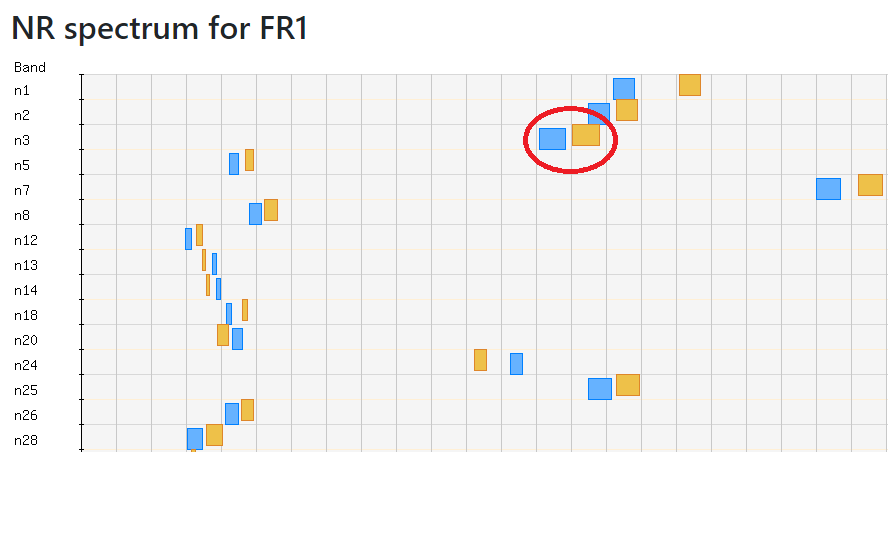

## Antenna Choice

- https://www.wifi-shop24.com/5g-4g-multiband-outdoor-panel-antenna-8dbi-mimo
- 8dBi @ 1700 - 2700 MHz

In [2]:
dl_bandwidth_hz = 20e6
dl_frequency_hz = 1842.5e6
dl_target_data_rate_bps = 15e6

ul_bandwidth_hz = 5e6
ul_frequency_hz = 1747.5e6
ul_target_data_rate_bps = 56e3

gnb_transmit_power_milli_watt = 1e3
gnb_cable_loss_db = 0.5
gnb_noise_figure_db = 5
gnb_receive_sensitivity_dbm = -102
gnb_antenna_gain_dbi = 8

ue_transmit_power_dbm = 21
ue_cable_loss_db = 0.5
ue_noise_figure_db = 9
ue_receive_sensitivity_dbm = -95
ua_antenna_gain_dbi = 0

In [3]:
spectral_efficiency_bps_per_hz = dl_target_data_rate_bps / dl_bandwidth_hz

print(f'spectral efficiency: {spectral_efficiency_bps_per_hz} bps/Hz')

spectral efficiency: 0.75 bps/Hz


## CQI Index

**Question:** Given these parameters, and the video requirements given higher up, calculate the theoretical CQI (MCS) index that would be required and derive the needed SNR from it.

**Answer:**
To achieve a rate of (at least) 15 Mbps on a 20 Mhz bandwidth, we need a spectral efficiency of 0.75 bps/Hz (or more).
Therefore, the minimum CQI index is 5, which uses QPSK modulation and an SINR estimate of 2.4 dB.

**Sources:**
- Course Slides Table 7.1

## Channel Propagation Model

**Question:** Choose a (suitable) wireless channel propagation model. Provide your rationale.

**Answer:**
We need to transmit packets from a tall building across the Schelde river to an open field with no obstructions.
Therefore, the simple `Friis` free space propagation model appears to be a suitable solution.

**Sources:**
- Course Slides Table 11.4

## Data Flow

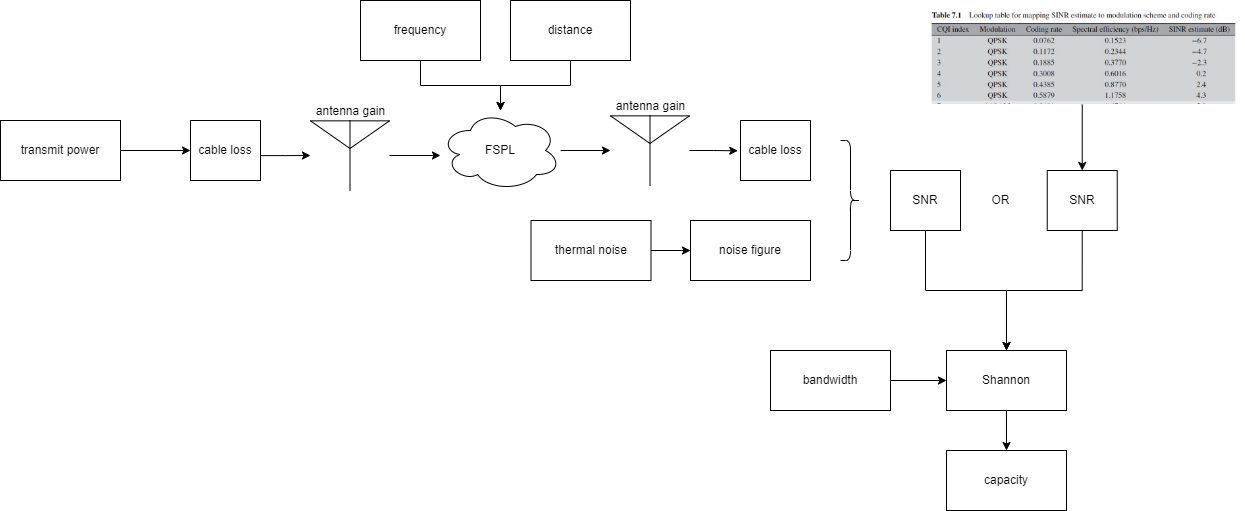

## Shannon

$$ \mathrm{SNR} = 2^{\frac{C}{B}} - 1 $$

- https://www.rfwireless-world.com/calculators/channel-capacity-calculator.html

In [4]:
def get_channel_snr(capacity_bps, bandwidth_hz):
    return math.pow(2, capacity_bps / bandwidth_hz) - 1

## Thermal Noise

- https://www.everythingrf.com/rf-calculators/noise-power-calculator

In [5]:
def get_ktb_noise_dbm(bandwidth_hz, temperature_k=290):
    k = 1.38e-23  # Boltzmann constant
    return 10 * math.log10((k * bandwidth_hz * temperature_k)/1e-3)

## Total Noise

$$ \mathrm{P_{total\_noise,dBm}} = P_\mathrm{ktb\_noise,dBm} + P_\mathrm{noise\_figure,dB} $$

## Receive Power

$$ \mathrm{SNR_{dB}} = P_\mathrm{signal,dBm} - P_\mathrm{noise,dBm} $$
$$ P_\mathrm{signal,dBm} = \mathrm{SNR_{dB}} + P_\mathrm{noise,dBm} $$

## Free Space Path Loss

- https://www.everythingrf.com/rf-calculators/free-space-path-loss-calculator

In [6]:
antenna_coordinates = [51.225779846347535, 4.400503131269632]
min_site_coordinates = [51.227090, 4.393261]
max_site_coordinates = [51.227990333375544, 4.389441701586266]

In [7]:
from geopy import distance

min_distance_m = distance.distance(antenna_coordinates, min_site_coordinates).m
max_distance_m = distance.distance(antenna_coordinates, max_site_coordinates).m

print(f'min distance: {min_distance_m:.2f} m')
print(f'max distance: {max_distance_m:.2f} m')

min distance: 526.48 m
max distance: 810.88 m


In [8]:
def get_fspl_db(distance_m, frequency_hz):
    return 20 * math.log10(distance_m) + 20 * math.log10(frequency_hz) - 147.55

## Power Gains

In [9]:
power_gains_db = gnb_antenna_gain_dbi + ua_antenna_gain_dbi - gnb_cable_loss_db - ue_cable_loss_db

print(f'power gains: {power_gains_db:.2f} dB')

power gains: 7.00 dB


## Target Transmit Power

$$ P_\mathrm{receive,dBm} = P_\mathrm{gains,dB} - P_\mathrm{FSPL,dB} + P_\mathrm{transmit,dBm} $$
$$ P_\mathrm{transmit,dBm} = P_\mathrm{receive,dBm} - P_\mathrm{gains,dB} + P_\mathrm{FSPL,dB} $$

## gNodeB Transmit Power

In [10]:
def calculate_gnb_transmit_power():
    channel_snr = get_channel_snr(dl_target_data_rate_bps, dl_bandwidth_hz)
    channel_snr_db = convert_ratio_to_db(channel_snr)
    
    print(f'channel SNR: {channel_snr:.2f} or {channel_snr_db:.2f} dB')
    
    ktb_noise_dbm = get_ktb_noise_dbm(dl_bandwidth_hz)
    
    print(f'thermal noise: {ktb_noise_dbm:.2f} dBm')
    
    total_noise_dbm = ktb_noise_dbm + ue_noise_figure_db
    
    print(f'total noise: {total_noise_dbm:.2f} dBm')
    
    receive_power_dbm = channel_snr_db + total_noise_dbm

    print(f'receive power: {receive_power_dbm:.2f} dBm')
    
    max_fspl_db = get_fspl_db(max_distance_m, dl_frequency_hz)

    print(f'max FSPL: {max_fspl_db:.2f} dB')
    
    transmit_power_dbm = receive_power_dbm - power_gains_db + max_fspl_db
    transmit_power_milli_watt = convert_dbm_to_milli_watt(transmit_power_dbm)

    print(f'target transmit power: {transmit_power_dbm:.2f} dBm or {transmit_power_milli_watt:.2f} mW')

In [11]:
calculate_gnb_transmit_power()

channel SNR: 0.68 or -1.66 dB
thermal noise: -100.97 dBm
total noise: -91.97 dBm
receive power: -93.63 dBm
max FSPL: 95.94 dB
target transmit power: -4.69 dBm or 0.34 mW


**Conclusion:** The gNodeB transmit power is very low.

## UE Transmit Power

In [12]:
def calculate_ue_transmit_power():
    channel_snr = get_channel_snr(ul_target_data_rate_bps, ul_bandwidth_hz)
    channel_snr_db = convert_ratio_to_db(channel_snr)
    
    print(f'channel SNR: {channel_snr:.2f} or {channel_snr_db:.2f} dB')
    
    ktb_noise_dbm = get_ktb_noise_dbm(ul_bandwidth_hz)
    
    print(f'thermal noise: {ktb_noise_dbm:.2f} dBm')
    
    total_noise_dbm = ktb_noise_dbm + gnb_noise_figure_db
    
    print(f'total noise: {total_noise_dbm:.2f} dBm')
    
    receive_power_dbm = channel_snr_db + total_noise_dbm

    print(f'receive power: {receive_power_dbm:.2f} dBm')
    
    max_fspl_db = get_fspl_db(max_distance_m, ul_frequency_hz)

    print(f'max FSPL: {max_fspl_db:.2f} dB')
    
    transmit_power_dbm = receive_power_dbm - power_gains_db + max_fspl_db
    transmit_power_milli_watt = convert_dbm_to_milli_watt(transmit_power_dbm)

    print(f'target transmit power: {transmit_power_dbm:.2f} dBm or {transmit_power_milli_watt:.2f} mW')

In [13]:
calculate_ue_transmit_power()

channel SNR: 0.01 or -21.08 dB
thermal noise: -106.99 dBm
total noise: -101.99 dBm
receive power: -123.07 dBm
max FSPL: 95.48 dB
target transmit power: -34.59 dBm or 0.00 mW


**Conclusion:** The UE transmit power is negligible.